Cilj:

- za zadanu sliku i dodanu datoteku, što manje komprimirati kvalitetu slike

- LIMIT: q (npr max_q = 32) i max upscale npr. max_upscale_h = 2 * h i max_upscale_w = 2 * w
- LIMIT: slika mora biti bar 5x5
- - ali ima opcija da ukines ograničenje za q, i tada je implicitno ograničenje q_max = 128
- - q = 2 ** n
- - n - koliko bita kratemo u svakom bytu slike
- - q - faktor kvantizacije, max magnituda za koji će se svaki kanal piksela promjeniti

In [141]:
# IMPORTS
import cv2
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import math


In [184]:
# * * * * * * * * * 
# HELPER FUNCTIONS


# zapravo SE KORISTE
####################

def convert_bytes(size_in_bits):
    size_in_bytes = size_in_bits / 8
    if size_in_bytes < 1024:
        return f"{size_in_bytes} Bytes"
    elif size_in_bytes < 1024**2:
        return f"{size_in_bytes / 1024:.2f} KB"
    elif size_in_bytes < 1024**3:
        return f"{size_in_bytes / 1024**2:.2f} MB"
    else:
        return f"{size_in_bytes / 1024**3:.2f} GB"
# vraca memorijsko zauzece u odgovarajucem formatu

def file_to_bits(file_path):
    with open(file_path, "rb") as file:
        byte_data = file.read()  
    bit_stream = ''.join(format(byte, '08b') for byte in byte_data)  # Convert to bits
    return bit_stream
# vraca info koliko bita ima zadani file

def optimal_n_finder(original_img_num_bits, data_add_num_bits, metadata_bits=48):
    # kalkulira optimalan n (q) s obzirom na velicinu originalne slike i dodatnih podataka
    # # uzima u obzir da nije cijela slika na raspolaganju, nego se u početku dio rezervira za metadata
    n_opt = (8 * data_add_num_bits) / (original_img_num_bits - (metadata_bits/4) * 8)

    if data_add_num_bits <= 0 or original_img_num_bits <= 0:
        return None

    if n_opt > 4 and n_opt < 8:
        print("TREBA UPSCALEat x2")
        return -2  # Optional: Suggest upscaling or give warning

    if n_opt >= 8 or n_opt <= 0:
        return None
    else:
        return n_opt
    
def possible_n(old_n, bits=12): 
    # not all n values are posible to save exactly, so to ensure we encode/decode with exactly same n, we introduce this wrapper function
    max_scaled = 2 ** bits
    if old_n>=8:
        print(f"Error: n has to be lower than 8!")
        print(f"Will autocast n to 7.9")
    old_n = min(old_n, 7.9)
    n_scale_real = (old_n * (max_scaled/8) )  
    n_scale_real_round = math.ceil(n_scale_real)
    new_n = n_scale_real_round * (8/max_scaled) 
    # treba voditi i racuna da je u range [0, 8>
    return new_n

def n_to_bits(n, bits = 12):
    # this is specific converter, mapping from custom ranges
    max_scaled = 2 ** bits
    if n>=8:
        print(f"Error: n has to be lower than 8!")
        print(f"Will autocast n to 7.9")
    n = min(n, 7.9)
    n_scale_real = (n * (max_scaled/8) )  
    n_scale_real_round = math.ceil(n_scale_real)
    #print("\t", n_scale_real_round)
    return format(n_scale_real_round, f'0{bits}b') 

def bits_to_n(stream_b, bits = 12):
    # this is specific converter, mapping from custom ranges
    max_scaled = 2 ** bits
    if len(stream_b) != bits:
        print(f"Error: stream of bits has size {len(stream_b)} but {bits} is expected!")
        return None
    n_scale_real = int(stream_b, 2)
    #print("\t", n_scale_real)
    n = (n_scale_real * (8/max_scaled) )
    return n


def bits_to_integer(bit_stream):
    # general purpose use

    #bit_stream = bit_stream.strip()
    
    if not all(bit in '01' for bit in bit_stream):
        raise ValueError("Input must be a string of bits (only '0' and '1') -> recieved:", bit_stream)
    
    return int(bit_stream, 2)


def integer_to_bits(number, num_bits):
    # general purpose use

    if number < 0:
        raise ValueError("Only non-negative integers are supported.")
    if number >= 2 ** num_bits:
        raise ValueError(f"Number {number} cannot be represented in {num_bits} bits.")
    
    return format(number, f'0{num_bits}b')

# podrzane ekstenzije za dodatne podatke
EXTENSION_MAP = {
    '.txt':  '0000',
    '.png':  '0001',
    '.jpg':  '0010',
    '.jpeg': '0011',
    '.pdf':  '0100',
    '.csv':  '0101',
    '.json': '0110',
    '.mp3':  '0111',
    '.wav':  '1000',
    '.zip':  '1001',
    '.mp4':  '1010',
    '.docx': '1011',
    '.xlsx': '1100',
    '.pptx': '1101',
    '.bin':  '1110',
    '.log':  '1111',
}

def is_supported_extension(ext):
    """
    Check if the file extension is supported in the EXTENSION_MAP.
        
    Returns:
        bool: True if supported, False otherwise
    """
    return ext.lower() in EXTENSION_MAP

def encode_extension(ext):
    ext = ext.lower()
    if ext not in EXTENSION_MAP:
        raise ValueError(f"Unsupported extension: {ext}")
    return EXTENSION_MAP[ext]

def decode_extension(bits):
    if len(bits) != 4 or not all(b in '01' for b in bits):
        raise ValueError("Extension bits must be a 4-bit binary string.")
    
    inv_map = {v: k for k, v in EXTENSION_MAP.items()}
    if bits not in inv_map:
        raise ValueError(f"Unknown 4-bit extension code: {bits}")
    return inv_map[bits]


def bitstream_to_file(bitstream, extension, output_path='recovered_file'):
    # Rekonstruira additional file iz bitstreama
    # Odmah sprema u memoriju

    # Validate the extension
    EXTENSION_MAP = {
        '.txt':  '0000',
        '.png':  '0001',
        '.jpg':  '0010',
        '.jpeg': '0011',
        '.pdf':  '0100',
        '.csv':  '0101',
        '.json': '0110',
        '.mp3':  '0111',
        '.wav':  '1000',
        '.zip':  '1001',
        '.mp4':  '1010',
        '.docx': '1011',
        '.xlsx': '1100',
        '.pptx': '1101',
        '.bin':  '1110',
        '.log':  '1111',
    }

    if extension not in EXTENSION_MAP:
        raise ValueError(f"Unsupported extension '{extension}'. Supported: {list(EXTENSION_MAP.keys())}")

    # Make sure bitstream length is a multiple of 8
    if len(bitstream) % 8 != 0:
        bitstream = bitstream[:len(bitstream) - (len(bitstream) % 8)]

    # Convert bitstream to bytes
    byte_data = bytes(int(bitstream[i:i+8], 2) for i in range(0, len(bitstream), 8))

    # Save to file
    full_path = output_path + extension
    with open(full_path, 'wb') as f:
        f.write(byte_data)
    
    print(f"Recovered file saved at: {full_path}")

    return full_path



    






# samo DEMONSTRACIJA
####################

def quantize_img(orig_img, q = 4):  # samo kvantizira
    new_image = np.zeros(orig_img.shape, dtype=np.uint8) # 24 bits per pixel

    for h in range(0, orig_img.shape[0]):
        for w in range(0, orig_img.shape[1]):
            
            for cc in range(0, orig_img.shape[2]):
                new_image[h][w][cc] = orig_img[h][w][cc] - (orig_img[h][w][cc]  % q)
    
    return new_image
# funkcija vrća kvantiziranu sliku, pretpostavlja ulaz u formatu (height, width, chanells). Može se podesiti faktor kvantizacije (q).
# npr. ako je piksel vrijednosti 167, a q=4 -> izlaz piksela 164; npr. ako je ulazni piksel 167 a q=8 -> izlaz piksela 160 ...
# finalno se ne koristi, jer se kvantizacija dogada dinamicki, tijekom enkodiranja, i prilagodena je
    

def quantize_rand_noise_img(orig_img, q = 4): # kvantizira i dodaje random inf na svaki piksel (simulira dodavanje add_file na sliku)
    new_image = np.zeros(orig_img.shape, dtype=np.uint8) # 24 bits per pixel

    for h in range(0, orig_img.shape[0]):
        for w in range(0, orig_img.shape[1]):
            
            for cc in range(0, orig_img.shape[2]):
                new_image[h][w][cc] = orig_img[h][w][cc] - (orig_img[h][w][cc]  % q)
                new_image[h][w][cc] += np.random.randint(0,q) ##
    
    return new_image
# vraca kvantiziranu sliku, ali joj dodaje random noise (simulira stvarno dodavanje informacije)
# koristi se samo za testiranje/demonstraciju, nema korist u finalnom proizvodu

    

In [156]:
# USER INPUT PARAMETERS

#q (2**k)
q = 4

#input image path - original image into wich additional data will be added
in_im_path = "/Users/tomislavmatanovic/Documents/FER/DOAS/Projekt/test_img1.jpeg"

#additional file path - addidtional data
# it will be converted to bits and embedded into the quantized original image
#add_data_path = "/Users/tomislavmatanovic/Documents/FER/KOMMRE/2.txt"
add_data_path = "/Users/tomislavmatanovic/Documents/Sunday Brunch/Season2024-2025/SundayBrunch2024-2025.xlsx"
#add_data_path = "/Users/tomislavmatanovic/Downloads/WhatsApp Image 2025-05-13 at 13.21.04.jpeg"

print("INPUT IMAGE:")
in_img = cv2.imread(in_im_path)
orig_img_shape = in_img.shape
print("------------------")
print(f"size - {convert_bytes(os.path.getsize(in_im_path))}")
print(f"shape - {in_img.shape}")



print("\n\nADDITIONAL DATA:")
print("------------------")
print(f"size - {convert_bytes(os.path.getsize(add_data_path))}")
print(f"type - {os.path.splitext(add_data_path)[1] }")


INPUT IMAGE:
------------------
size - 94.21 KB
shape - (601, 799, 3)


ADDITIONAL DATA:
------------------
size - 19.19 KB
type - .xlsx


In [ ]:
# QUANTIZATION of input image
# samo demonstracija

in_img2 = cv2.imread("/Users/tomislavmatanovic/Downloads/GZSpy5hWsAE_JrB.jpg-large.jpeg")


for kv in [2, 4, 8, 16, 32, 64, 128]:
    kv_img = quantize_img(in_img, q = kv)
    kv_img22 = quantize_img(in_img2, q = kv)
    print(kv)
    kvnoise_img = quantize_rand_noise_img(in_img, q = kv)
    kvnoise_img22 = quantize_rand_noise_img(in_img2, q = kv)


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the kv_img
    axes[0].imshow(cv2.cvtColor(kv_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Quantized (q={kv})")
    axes[0].axis('off')  # Hide axes for better visualization
    
    # Plot the kvnoise_img
    axes[1].imshow(cv2.cvtColor(kvnoise_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Quantized with Noise (q={kv})")
    axes[1].axis('off')  # Hide axes for better visualization
    
    # Show the plots
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the kv_img
    axes[0].imshow(cv2.cvtColor(kv_img22, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Quantized (q={kv})")
    axes[0].axis('off')  # Hide axes for better visualization
    
    # Plot the kvnoise_img
    axes[1].imshow(cv2.cvtColor(kvnoise_img22, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Quantized with Noise (q={kv})")
    axes[1].axis('off')  # Hide axes for better visualization
    
    # Show the plots
    plt.show()


reshaped_img = kv_img.reshape(-1, kv_img.shape[2])

# Find the unique rows (unique pixel values)
unique_pixels, counts = np.unique(reshaped_img, axis=0, return_counts=True)

# Print how many unique pixels and what those pixels are
print(f"Number of unique pixels: {len(unique_pixels)}")
print(f"Unique pixel values: \n{unique_pixels}")

# If you also want to know how many times each unique pixel occurs
print(f"Pixel counts: \n{dict(zip(map(tuple, unique_pixels), counts))}")



reshaped_img = kv_img22.reshape(-1, kv_img22.shape[2])

# Find the unique rows (unique pixel values)
unique_pixels, counts = np.unique(reshaped_img, axis=0, return_counts=True)

# Print how many unique pixels and what those pixels are
print(f"Number of unique pixels: {len(unique_pixels)}")
print(f"Unique pixel values: \n{unique_pixels}")

# If you also want to know how many times each unique pixel occurs
print(f"Pixel counts: \n{dict(zip(map(tuple, unique_pixels), counts))}")

######


print()
print("old size:", in_img2.nbytes)
print("quantized size:", kv_img22.nbytes)


KeyboardInterrupt: 

In [146]:
# CONVERT additional data into bits

# compress this raw data (something reversable), lz77 or something

# bits_for_length + raw_data + bits_for_type?(png, jpg, pdf, mp3) # VJV NECEMO OVAKO
# q + bits_for_type + RAW_data




# Example usage
bit_stream = file_to_bits(add_data_path)
print(f"Total bits: {len(bit_stream)}")
print(f"First 100 bits: {bit_stream[:100]}") 
print(f"First n bits: {bit_stream[:10]}") 

Total bits: 1400
First 100 bits: 0100101001001101010000100100000101000111001111010011000000110000001100110011011000110101001101000011
First n bits: 0100101001


In [ ]:
# ISKALKULIRAJ OPTIMALAN q / OPTIMALAN n
# oni su povezani preko formule: q = 2**n
# - PREKVANTIZACIJA
# BOLJE zapisivati n u sliku nego q, jer imamo ograničenu preciznost (broj bitova), a n ide u eksponent pa je manje osjetljiv
# n se zapšisuje u svaku sliku, u prva 2 pixela, prva 6 kanala boje uzimamo 2 bita i zapisujemo n u uint8, dakle n je definiran s 12 bit-a
# n će biti u rasponu 0 - 7, taj raspon predstavljamo s 12bita, što nam omogućuje korak od 0.0017, dakle dosta(dovoljno) realno možemo prikazati n
# - treba funkcija za transformaciju n->12bita i 12bita->n







n = 0.1111
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 7
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 0
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()


# n = 34.1111
# print("n:", n)
# x = n_to_bits(n, bits=2)
# print(x)
# print(bits_to_n(x, bits=2))
# print()


n = 2.1111
print("n:", n)
x = n_to_bits(n, bits=4)
print(x)
print(bits_to_n(x, bits=4))
print()
print()

n = 2.1111
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 0
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 1
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 2
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 3
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 4
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 5
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 6
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 7
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()

n = 8
print("n:", n)
x = n_to_bits(n, bits=12)
print(x)
print(bits_to_n(x, bits=12))
print()
print()





n: 0.1111
000000111001
0.111328125


n: 7
111000000000
7.0


n: 0
000000000000
0.0


n: 2.1111
0101
2.5


n: 2.1111
010000111001
2.111328125


n: 0
000000000000
0.0


n: 1
001000000000
1.0


n: 2
010000000000
2.0


n: 3
011000000000
3.0


n: 4
100000000000
4.0


n: 5
101000000000
5.0


n: 6
110000000000
6.0


n: 7
111000000000
7.0


n: 8
Error: n has to be lower than 8!
Will autocast n to 7.9
111111001101
7.900390625




In [148]:
test_values = [
    (0, 12, 0.0),   # Edge case: lowest possible n
    (1, 12, 1.001953125),   # Normal case
    (3.5, 12, 3.501953125), # Normal case
    (1.52153, 12, 1.001953125),   # Normal case
    (4.4444, 12, 3.501953125), # Normal case
    (7.9, 12, 7.9),         # Upper bound within range
    (8.0, 12, 7.9),         # Out of bounds (should autocast to 7.9)
    (4.3, 12, 4.3046875),   # Another normal case
    (7.5, 12, 7.501953125), # High value within range
]

for n, bits, _ in test_values:
    expected = bits_to_n(n_to_bits(n, bits=12), bits=12)
    result = possible_n(n, bits)
    print("n in bits(12):", n_to_bits(result))
    print(f"Input: {n}, Bits: {bits} -> Quantized: {result}, Expected: {expected}, Match: {math.isclose(result, expected, rel_tol=1e-6)}")
    print()

n in bits(12): 000000000000
Input: 0, Bits: 12 -> Quantized: 0.0, Expected: 0.0, Match: True

n in bits(12): 001000000000
Input: 1, Bits: 12 -> Quantized: 1.0, Expected: 1.0, Match: True

n in bits(12): 011100000000
Input: 3.5, Bits: 12 -> Quantized: 3.5, Expected: 3.5, Match: True

n in bits(12): 001100001100
Input: 1.52153, Bits: 12 -> Quantized: 1.5234375, Expected: 1.5234375, Match: True

n in bits(12): 100011100100
Input: 4.4444, Bits: 12 -> Quantized: 4.4453125, Expected: 4.4453125, Match: True

n in bits(12): 111111001101
Input: 7.9, Bits: 12 -> Quantized: 7.900390625, Expected: 7.900390625, Match: True

Error: n has to be lower than 8!
Will autocast n to 7.9
Error: n has to be lower than 8!
Will autocast n to 7.9
n in bits(12): 111111001101
Input: 8.0, Bits: 12 -> Quantized: 7.900390625, Expected: 7.900390625, Match: True

n in bits(12): 100010011010
Input: 4.3, Bits: 12 -> Quantized: 4.30078125, Expected: 4.30078125, Match: True

n in bits(12): 111100000000
Input: 7.5, Bits: 1

In [ ]:
#input image path - original image into wich additional data will be added
in_im_path = "/Users/tomislavmatanovic/Documents/FER/DOAS/Projekt/test_img1.jpeg"

#additional file path - addidtional data
# it will be converted to bits and embedded into the quantized original image
#add_data_path = "/Users/tomislavmatanovic/Documents/FER/KOMMRE/2.txt"
#add_data_path = "/Users/tomislavmatanovic/Documents/Sunday Brunch/Season2024-2025/SundayBrunch2024-2025.xlsx"
add_data_path = "/Users/tomislavmatanovic/Downloads/3c80e4cc-efc8-4417-b80a-c0bcd69aaf6c.JPG"

print("INPUT IMAGE:")
in_img = cv2.imread(in_im_path)
orig_img_shape = in_img.shape
print("------------------")
#print(f"size - {convert_bytes(os.path.getsize(in_im_path))}")
print(f"shape - {in_img.shape}")
print("bits -", convert_bytes(in_img.shape[0] * in_img.shape[1] * in_img.shape[2] * 8))



print("\n\nADDITIONAL DATA:")
print("------------------")
#print(f"size - {convert_bytes(os.path.getsize(add_data_path))}")
print(f"type - {os.path.splitext(add_data_path)[1] }")
print("bits -", convert_bytes(len(file_to_bits(add_data_path))) )

INPUT IMAGE:
------------------
size - 11.78 KB
shape - (601, 799, 3)
bits - 1.37 MB


ADDITIONAL DATA:
------------------
size - 37.96 KB
type - .JPG
bits - 303.65 KB


In [193]:
# * * * * * * * * * 
# ENKODIRANJE (main code)


# def encode (..... n=-1) -> n=-1 znaci da treba naci optimalan n, inace koristi zadani n

def encode(original_image, additional_data_path, n=-1, VERBOSE = False): # -> n=-1 znaci da treba naci optimalan n, inace koristi zadani n

    # provjera je li additional data file type podrzan!
    ext = os.path.splitext(additional_data_path)[1] 
    if not is_supported_extension(ext):
        print(f"[!] Unsupported extension: {ext}")
        print("Supported extensions are:", ', '.join(sorted(EXTENSION_MAP.keys())))
        return None

    data_mask_img = np.zeros(in_img.shape, dtype=np.uint8) # 24 bits per pixel # first 4 pixels are to store metadata (n_opt)
    bit_stream = file_to_bits(additional_data_path)    # add_data_path)

    if n == -1: # nađi optimalni n_opt_poss

        orig_img_shape = original_image.shape
        if len(orig_img_shape) == 3:
            original_img_num_bits = orig_img_shape[0] * orig_img_shape[1] * orig_img_shape[2] * 8
        else: # for b/w photos
            original_img_num_bits = orig_img_shape[0] * orig_img_shape[1] * 8

        n_opt = optimal_n_finder(original_img_num_bits, len(bit_stream))
        if n_opt == -2:
            # upscale x2 image and work with that
            print("[!] Not enough space. Automatically upscaling the image by 2x...")


            upscaled_img = cv2.resize(orig_img, (orig_img.shape[1]*2, orig_img.shape[0]*2), interpolation=cv2.INTER_LINEAR)

            orig_img = upscaled_img  # replace the original
            orig_img_shape = orig_img.shape  # update shape
            original_img_num_bits = orig_img.size * 8  # update bit count

            # Recompute after upscaling
            n_opt = optimal_n_finder(original_img_num_bits, len(bit_stream))
            if n_opt is None:
                raise ValueError("Still not enough space or invalid input after upscaling.")
        
        n_poss = possible_n(n_opt) 

    else:
        n_poss = n

    


    len_add_data = len(bit_stream)
    
    # !!
    full_add_data = n_to_bits(n=n_poss, bits=12) + integer_to_bits(len_add_data, num_bits=32) + encode_extension(ext) + bit_stream # metdata + add_data # MAPIRAJ file type
    # !!
    

    n_real = n_poss // 1
    n_decimal = n_poss % 1
    pix_ch_i = -12
    stream_pointer = 0

    if True:
        print("llen:", len_add_data)
        print("LEN FULL DATA:", len(full_add_data))
        print("metadata:", n_to_bits(n=n_poss, bits=12))
        print("n_opt_poss:", n_poss, "->", n_real, n_decimal)

        print("-------------")
        print("-------------")
        print()

    for h in range(0, in_img.shape[0]):
        for w in range(0, in_img.shape[1]):
            for cc in range(0, in_img.shape[2]):
                
                # if h>3 or w>4: ###OBRISI!!!
                #     break

                if stream_pointer >= len(full_add_data): # very important, to know when whole data is loaded
                    break

                #zapiši metapodatak (n)
                if pix_ch_i < 0:
                    n_curr = 4
                    q = 2 ** n_curr
                    bits_curr = full_add_data[stream_pointer:(stream_pointer+n_curr)]
                    stream_pointer += n_curr

                    original_image[h][w][cc] = original_image[h][w][cc] - (original_image[h][w][cc]  % q)
                    data_mask_img[h][w][cc] = bits_to_integer(bits_curr) #
                    if VERBOSE:
                        print("bits_curr:", bits_curr)
                        print("quan_img[h][w][cc]:", original_image[h][w][cc])
                        print("bits_to_integer(bits_curr):", bits_to_integer(bits_curr))
                        print("MMMMMM")
                        print("MMMMMM")
                        print("MMMMMM")
                
                    
                    
                else:
                    # n je decimalan
                    if n_decimal > 0:
                        if VERBOSE:
                            print("HEYYY", n_poss, "----", n_decimal)
                        
                        #poseban pixo-kanal di zapisujemo više info
                        if pix_ch_i % ( math.floor(1 / n_decimal) ) == 0: #ceil ili floor
                            if VERBOSE:
                                print("PoSeBAn")
                            # dodaj math.ceil(n_poss) (zadnja bita)
                            n_curr = math.ceil(n_poss)
                            q = 2 ** n_curr
                            bits_curr = full_add_data[stream_pointer:(stream_pointer+n_curr)]
                            # IF THERE IS NO ENOUGH LEFT -> add zero to end, BUT encode exact expected length
                            stream_pointer += n_curr
                            original_image[h][w][cc] = original_image[h][w][cc] - (original_image[h][w][cc]  % q)
                            data_mask_img[h][w][cc] = bits_to_integer(bits_curr) #
                            ##
                            if VERBOSE:
                                print("bits_curr:", bits_curr)
                                print("quan_img[h][w][cc]:", original_image[h][w][cc])
                                print("bits_to_integer(bits_curr):", bits_to_integer(bits_curr))
                                print("after[h][w][cc]:", data_mask_img[h][w][cc])
                                print("PPPPPP")
                                print("PPPPPP")
                                print("PPPPPP")

                        #obican piksokanal, obicno upisivanje
                        else: 
                            if VERBOSE:
                                print("OBIcaN")
                            # dodaj math.floor(n_poss) (zadnja bita)
                            n_curr = math.floor(n_poss)
                            q = 2 ** n_curr
                            bits_curr = full_add_data[stream_pointer:(stream_pointer+n_curr)]
                            # IF THERE IS NO ENOUGH LEFT -> add zero to end, BUT encode exact expected length
                            stream_pointer += n_curr
                            original_image[h][w][cc] = original_image[h][w][cc] - (original_image[h][w][cc]  % q)
                            if n_curr > 0:
                                data_mask_img[h][w][cc] = bits_to_integer(bits_curr) #
                                if VERBOSE:
                                    print("bits_curr:", bits_curr)
                                    print("quan_img[h][w][cc]:", original_image[h][w][cc])
                                    print("bits_to_integer(bits_curr):", bits_to_integer(bits_curr))
                                    print("after[h][w][cc]:", data_mask_img[h][w][cc])
                                    print("OOOOOO")
                                    print("OOOOOO")
                                    print("OOOOOO")

                    #n je prirodan broj
                    else: 
                        if VERBOSE:
                            print("ALOHA", n_poss, "----", n_decimal)
                        # svugdje isto dodaj (possible_n) zadnja bita
                        n_curr = n_poss
                        q = 2 ** n_curr
                        bits_curr = full_add_data[stream_pointer:(stream_pointer+n_curr)]
                        stream_pointer += n_curr
                        original_image[h][w][cc] = original_image[h][w][cc] - (original_image[h][w][cc]  % q)
                        if n_curr > 0:
                            data_mask_img[h][w][cc] = bits_to_integer(bits_curr) #

    
                if VERBOSE:
                    print("stream_idx:", stream_pointer)
                    print("--pozicija:", h, ",", w, ",", cc)
                    print()
                    
                pix_ch_i += 1


    return original_image + data_mask_img, data_mask_img

processed_img, samo_maska = encode(in_img, add_data_path, VERBOSE=False)


llen: 2487488
LEN FULL DATA: 2487536
metadata: 001101110101
n_opt_poss: 1.728515625 -> 1.0 0.728515625
-------------
-------------



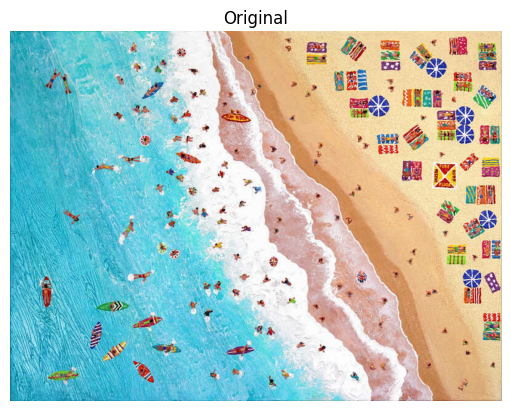

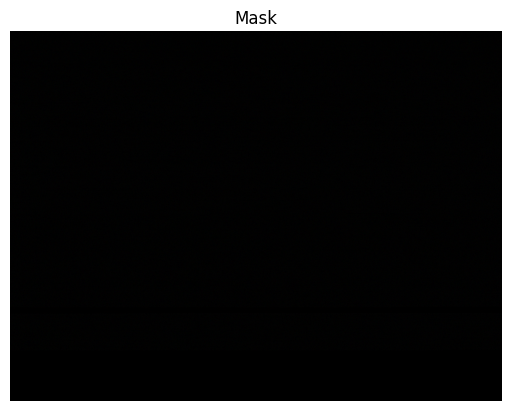

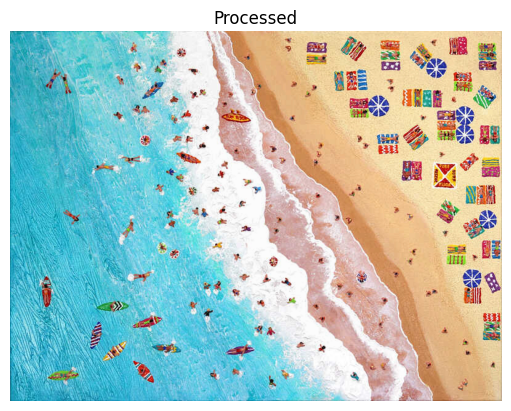

(601, 799, 3)
Images are exactly the same!


In [192]:
#KRATKA PROVJERICA
# nije bitno
# maska se čini cijela crna jer su u njoj pikseli male vrijednosti (tamno)

# Convert BGR to RGB for correct color display
image_rgb = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Original")
plt.axis('off')
plt.show()


image_rgb = cv2.cvtColor(samo_maska, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Mask")
plt.axis('off')
plt.show()


# Convert BGR to RGB for correct color display
image_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Processed")
plt.axis('off')
plt.show()

print(processed_img.shape)


are_identical = np.array_equal(in_img, processed_img)

if are_identical:
    print("Images are exactly the same!")
else:
    print("Images differ.")

In [194]:
# * * * * * * * * * 
# DEKODIRANJE SLIKE -> separacija slika, add_data
# (main code)

# if n_decod == 0, nema data, nepromijenjena slika!


# prima maskiranu sliku, odjeljuje orginalnu (kvantiziranu) sliku od additional_data_bits


def decode(processed_img, VERBOSE = False):

    metadata_bitstream = ''
    add_data_bitstream = ''
    ext_type = ''
    stream_len = -1
    n_opt_poss = -1
    n_real = -1
    n_decimal = -1
    stream_cnt = 0

    pix_ch_i = -12
    

    for h in range(0, in_img.shape[0]):
        for w in range(0, in_img.shape[1]):
            for cc in range(0, in_img.shape[2]):

                # if h>3 or w>4: ###OBRISI!!!
                #     break

                # print("--pozicija:", h, ",", w, ",", cc)
                # print("before[h][w][cc]:", processed_img[h][w][cc])
                # print()

                if (stream_len != -1) and (stream_cnt>=stream_len):
                    break

                if pix_ch_i < 0: # extract metadata
                    n_curr = 4
                    q = 2 ** n_curr
                    excess = processed_img[h][w][cc]  % q
                    metadata_bitstream += integer_to_bits(excess, num_bits=n_curr)
                    processed_img[h][w][cc] = processed_img[h][w][cc] - excess # in-place


                
                else: # extract additional data
                    if pix_ch_i == 0:
                        n_metadata = metadata_bitstream[0:12]
                        len_metadata = metadata_bitstream[12:44]
                        type_metadata = metadata_bitstream[44:]
                        n_opt_poss = bits_to_n(n_metadata, bits = 12)
                        n_real = n_opt_poss // 1
                        n_decimal = n_opt_poss % 1
                        stream_len = bits_to_integer(len_metadata)
                        ext_type = decode_extension(type_metadata)

                        if VERBOSE:
                            print("n_real:", n_real)
                            print("n_decimal:", n_decimal)
                            print("metadata_len:", len(metadata_bitstream))
                            print("stream_len:", stream_len)

                    
                    
                    # n je decimalan
                    if n_decimal > 0:

                        #poseban pixo-kanal di je zapisano više info
                        if pix_ch_i % ( math.floor(1 / n_decimal) ) == 0:
                            n_curr = math.ceil(n_opt_poss)
                            q = 2 ** n_curr
                            excess = processed_img[h][w][cc] % q
                            add_data_bitstream += integer_to_bits(excess, num_bits=n_curr)
                            processed_img[h][w][cc] = processed_img[h][w][cc] - excess # in-place
                            stream_cnt += n_curr


                        #obican piksokanal, obicno upisivanje
                        else: 
                            n_curr = math.floor(n_opt_poss)
                            if n_curr > 0:
                                q = 2 ** n_curr
                                excess = processed_img[h][w][cc] % q
                                add_data_bitstream += integer_to_bits(excess, num_bits=n_curr)
                                processed_img[h][w][cc] = processed_img[h][w][cc] - excess # in-place
                                stream_cnt += n_curr


                    # n je prirodan broj
                    else: 
                        n_curr = n_opt_poss
                        if n_curr > 0:
                            q = 2 ** n_curr
                            excess = processed_img[h][w][cc] % q
                            add_data_bitstream += integer_to_bits(excess, num_bits=n_curr)
                            processed_img[h][w][cc] = processed_img[h][w][cc] - excess # in-place
                            stream_cnt += n_curr


                pix_ch_i += 1

    # if (len(add_data_bitstream) > stream_len), crop excess from the end
    if len(add_data_bitstream) > stream_len:
        add_data_bitstream = add_data_bitstream[:stream_len]
    
    return processed_img, (add_data_bitstream, ext_type)


back_quant_orig_img, back_extra_data = decode(processed_img, VERBOSE = True)

print(len(back_extra_data))


n_real: 1.0
n_decimal: 0.728515625
metadata_len: 48
stream_len: 2487488
2


In [198]:
# TESTIRANJE
# nije bitno

bit_stream = file_to_bits(add_data_path)
if bit_stream == back_extra_data[0]:
    print("Strings are exactly the same!")
else:
    print("Strings are different.")

print()
print()


bit_stream = file_to_bits(add_data_path)
print(bit_stream[:100])
print(back_extra_data[0][:100])
print()
print(bit_stream[-100:])
print(back_extra_data[0][-100:])

Strings are exactly the same!


1111111111011000111111111110000000000000000100000100101001000110010010010100011000000000000000010000
1111111111011000111111111110000000000000000100000100101001000110010010010100011000000000000000010000

1001100000011010111111111010000101000110111011111101000000000110111001110010001011011111111111011001
1001100000011010111111111010000101000110111011111101000000000110111001110010001011011111111111011001


In [200]:
# TESTIRANJE REKONSTRUKCIJE FILE-a

path = bitstream_to_file(back_extra_data[0], back_extra_data[1])


Recovered file saved at: recovered_file.jpg
